In [1]:
import sys


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter


import seaborn as sb

from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.inspection import PartialDependenceDisplay

#from eli5.sklearn import PermutationImportance

import xgboost as xgb

#import shap

import warnings
warnings.filterwarnings('ignore')

from loader_parser import *
from ingenierie import *

In [2]:
data_path="/home/mchelfi/Desktop/PROJET_NHL/raw"

In [3]:
df_train = organiser(data_path,2016,2019)
df_train = encode_column(df_train, 'IS_EMPTY_NET')
df_train = encode_column(df_train, 'IS_GOAL')
df_train.shape

(251879, 24)

In [4]:
df_train['DISTANCE'] = df_train.apply(lambda row: distance(row), axis = 1)
df_train['ANGLE']    = df_train.apply(lambda row: angle(row), axis = 1)

**Section 2**

In [5]:
df_train.shape

(251879, 26)

In [6]:
df_q1 = df_train[['DISTANCE','ANGLE','IS_GOAL','IS_EMPTY_NET']].copy()

In [7]:
goals = df_q1[df_q1['IS_GOAL'] == 1]['DISTANCE']
no_goals = df_q1[df_q1['IS_GOAL'] == 0]['DISTANCE']

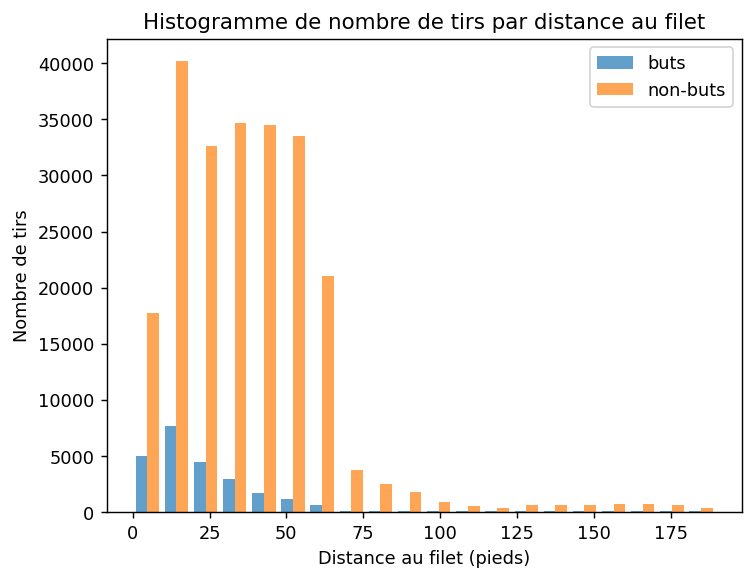

In [8]:
plt.figure(dpi=128)
plt.hist([goals, no_goals], bins=20, alpha=0.7, label=['buts', 'non-buts'])
plt.xlabel('Distance au filet (pieds)')
plt.ylabel('Nombre de tirs')
plt.title('Histogramme de nombre de tirs par distance au filet')
plt.legend()
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect2_hist_dist.png', dpi=150)
plt.show()


In [9]:
goals = df_q1[df_q1['IS_GOAL'] == 1]['ANGLE']
no_goals = df_q1[df_q1['IS_GOAL'] == 0]['ANGLE']

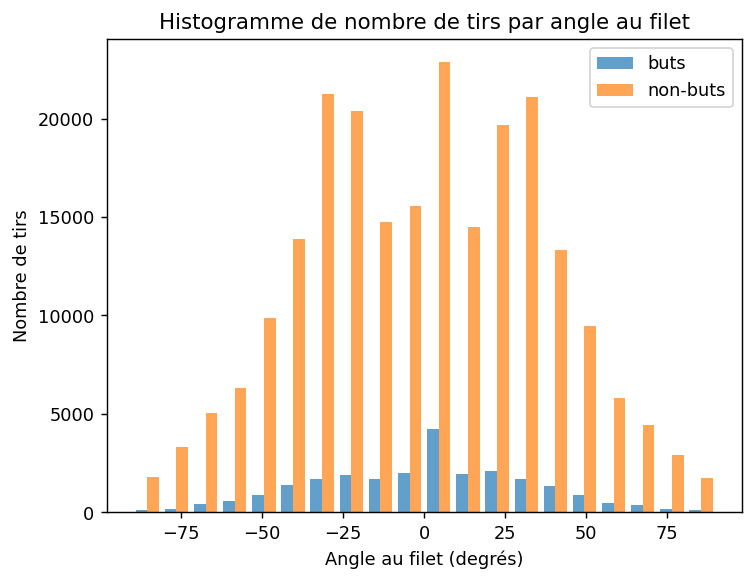

In [10]:
plt.figure(dpi=128)
plt.hist([goals, no_goals], bins=20, alpha=0.7, label=['buts', 'non-buts'])
plt.xlabel('Angle au filet (degrés)')
plt.ylabel('Nombre de tirs')
plt.title('Histogramme de nombre de tirs par angle au filet')
plt.legend()
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect2_hist_angle.png', dpi=150)
plt.show()

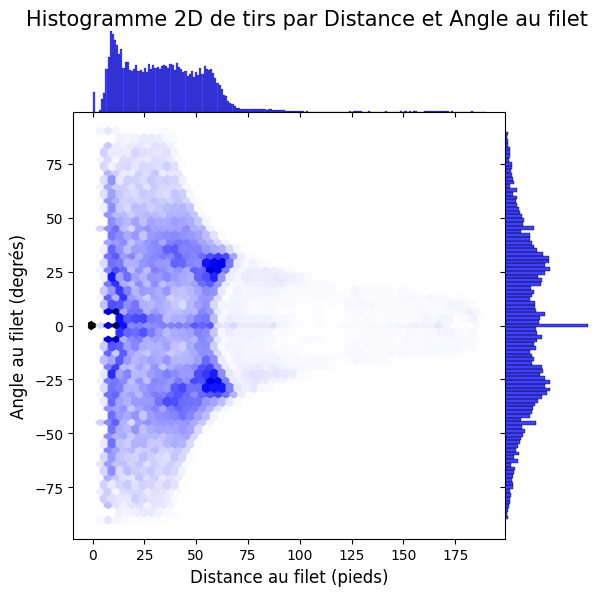

In [11]:
joint_plot = sb.jointplot(x='DISTANCE', y='ANGLE', data=df_q1, kind="hex", color="blue", space=0)
joint_plot.set_axis_labels('Distance au filet (pieds)', 'Angle au filet (degrés)', fontsize=12)
joint_plot.fig.suptitle('Histogramme 2D de tirs par Distance et Angle au filet', fontsize=15)
joint_plot.fig.subplots_adjust(top=0.95)
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect2_hist2d_dist_angle.png', dpi=150)
plt.show()

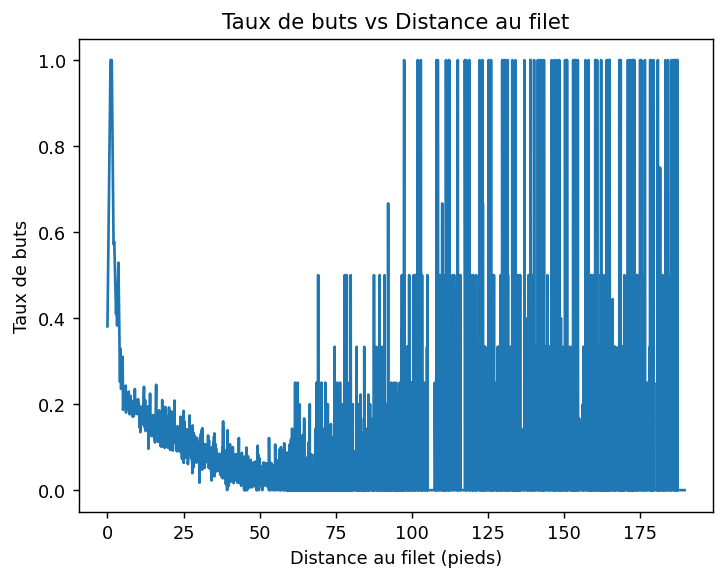

In [12]:
plt.figure(dpi=128)
goal_rate_by_distance = df_q1.groupby('DISTANCE')['IS_GOAL'].mean().reset_index()

sb.lineplot(x='DISTANCE', y='IS_GOAL', data=goal_rate_by_distance)
plt.title('Taux de buts vs Distance au filet')
plt.xlabel('Distance au filet (pieds)')
plt.ylabel('Taux de buts')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect2_taux_buts_distance.png', dpi=150)
plt.show()

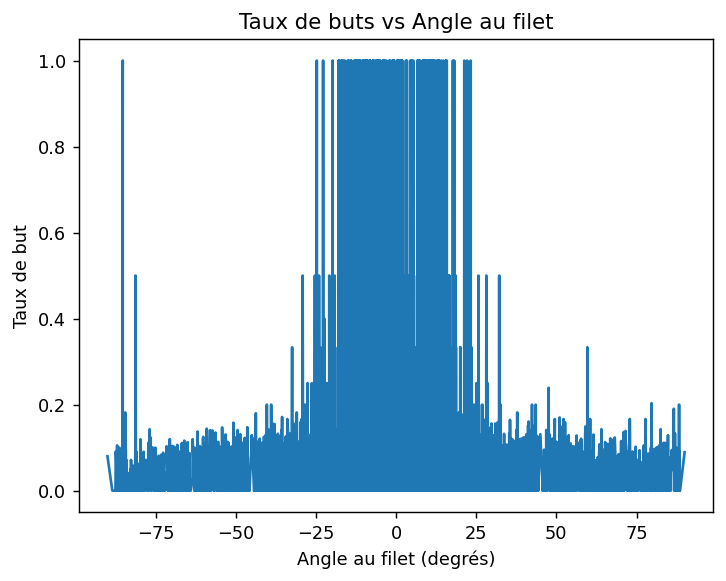

In [13]:
plt.figure(dpi=128)
goal_rate_by_angle = df_q1.groupby('ANGLE')['IS_GOAL'].mean().reset_index()

sb.lineplot(x='ANGLE', y='IS_GOAL', data=goal_rate_by_angle)
plt.title('Taux de buts vs Angle au filet')
plt.xlabel('Angle au filet (degrés)')
plt.ylabel('Taux de but')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect2_taux_buts_angle.png', dpi=150)
plt.show()

In [14]:
goals_df = df_q1[df_q1['IS_GOAL'] == 1]
empty_net_goals = goals_df[goals_df['IS_EMPTY_NET'] == 1]['DISTANCE']
non_empty_net_goals = goals_df[goals_df['IS_EMPTY_NET'] == 0]['DISTANCE']

Les buts avec filet non vides tirees depuis la zone defensive

In [15]:
buts_improbables = (non_empty_net_goals > 125).sum()
print('buts_improbables =',buts_improbables, ', GAME_ID =', df_train.iloc[18436]['GAME_ID'], ', PLAY_ID =', df_train.iloc[18436]['PLAY_ID'],
      ', COORONNEES = (', df_train.iloc[18436]['COORD_X'],',', df_train.iloc[18436]['COORD_Y'],')')

buts_improbables = 95 , GAME_ID = 2019020288 , PLAY_ID = 291 , COORONNEES = ( -73.0 , 8.0 )


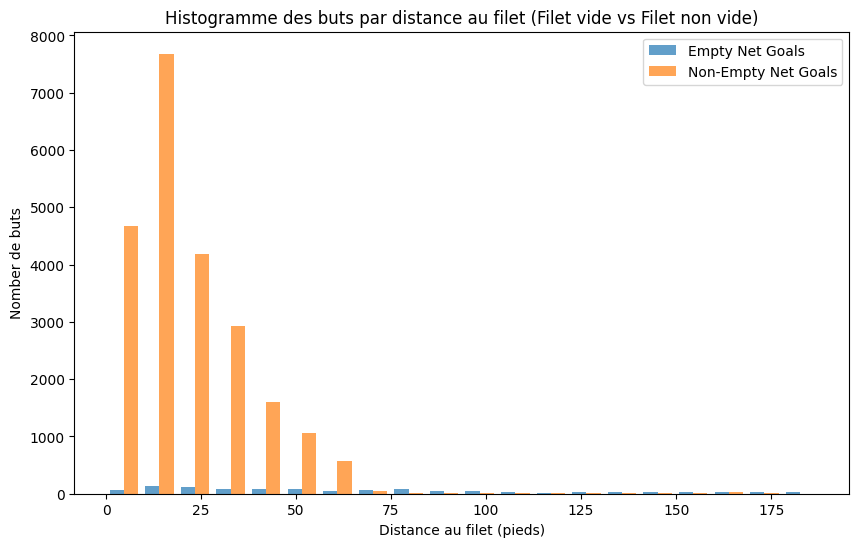

In [16]:
plt.figure(figsize=(10, 6))
plt.hist([empty_net_goals, non_empty_net_goals], bins=20, alpha=0.7, label=['Empty Net Goals', 'Non-Empty Net Goals'])

plt.xlabel('Distance au filet (pieds)')
plt.ylabel('Nomber de buts')
plt.title('Histogramme des buts par distance au filet (Filet vide vs Filet non vide)')
plt.legend()
plt.show()

**Section 3**

In [17]:
df_q2 = df_q1.dropna(subset=['DISTANCE','IS_GOAL'])
X = df_q2[['DISTANCE']]
y = df_q2['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )

In [18]:
clf = LogisticRegression()
clf.fit( X_train, y_train )

LogisticRegression()

In [19]:
y_pred = clf.predict(X_val)

In [20]:
report = classification_report(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f"La precision est: {accuracy}")
print(report)

La precision est: 0.9058281721454661
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     45632
           1       0.00      0.00      0.00      4744

    accuracy                           0.91     50376
   macro avg       0.45      0.50      0.48     50376
weighted avg       0.82      0.91      0.86     50376



In [21]:
y_score = clf.predict_proba(X_val)

# la deuxieme colomne nous les probabilites des buts esperes
goal_probabilities = y_score[:, 1]

a. Les courbes Receiver Operating Characteristic (ROC) et la métrique AUC de la
courbe ROC

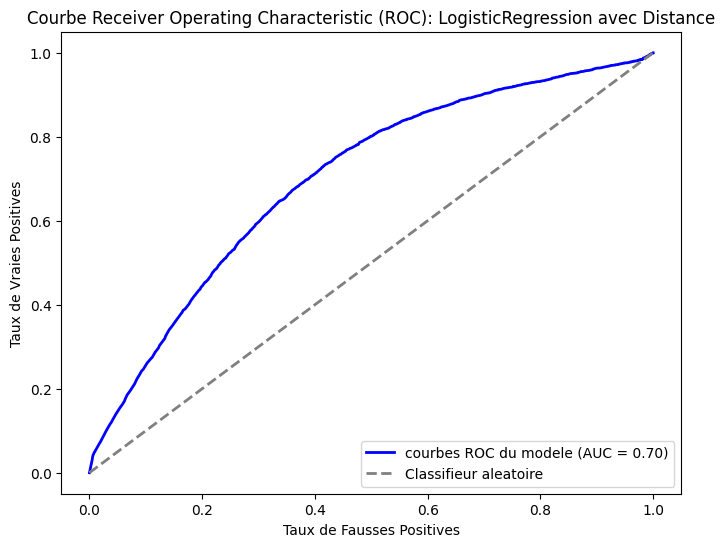

In [22]:
tracer_courbe_roc(y_val, goal_probabilities, 'LogisticRegression avec Distance','/milestone2/image/sect3_roc_distance_LR.png')

b. Le taux de buts (#buts / (#non_buts + #buts)) comme une fonction du centile de
la probabilité de tir donnée par le modèle, c'est-à-dire que si une valeur est au
70e centile, elle est supérieure à 70% des données.

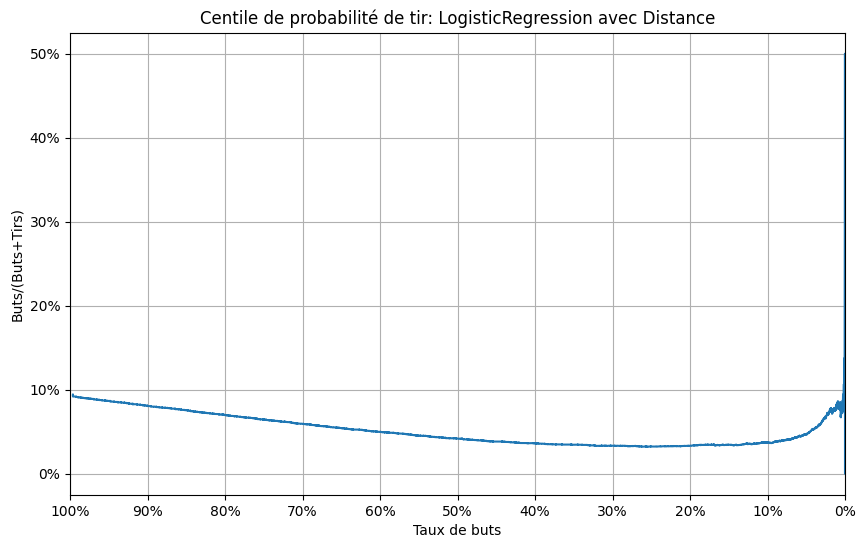

In [23]:
trace_courbe_taux_buts(y_val, goal_probabilities,'LogisticRegression avec Distance','/milestone2/image/sect3_taux_buts_distance_LR.png' )

c. La proportion cumulée de buts (pas de tirs) comme une fonction du centile de la
probabilité de tir donnée par le modèle,

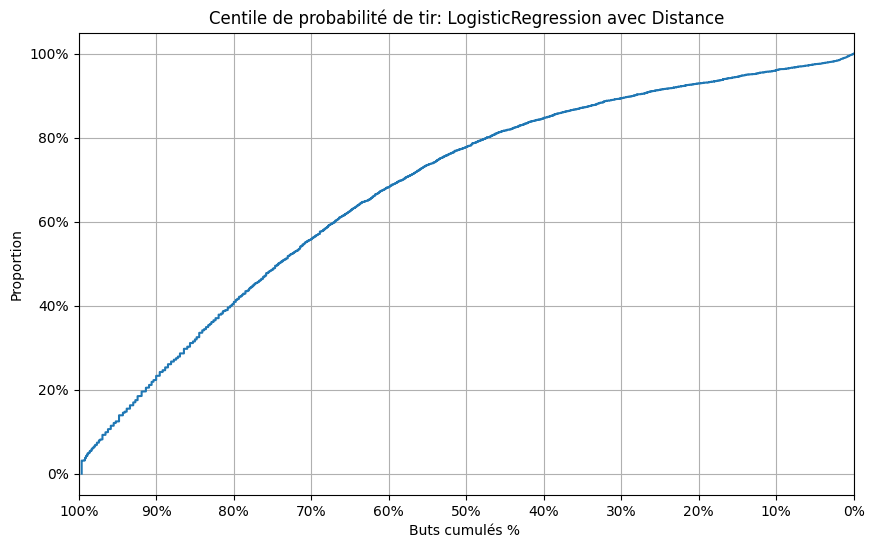

In [27]:
tracer_courbe_proportion(y_val, goal_probabilities, 'LogisticRegression avec Distance','/milestone2/image/sect3_proportion_distance_LR.png')

d. Le diagramme de fiabilité (courbe de calibration). Scikit-learn fournit des
fonctionnalités pour créer un diagramme de fiabilité en quelques lignes de code ;
consultez l'API CalibrationDisplay (en particulier les méthodes
.from_estimator() ou .from_predictions() ) pour plus d'informations.

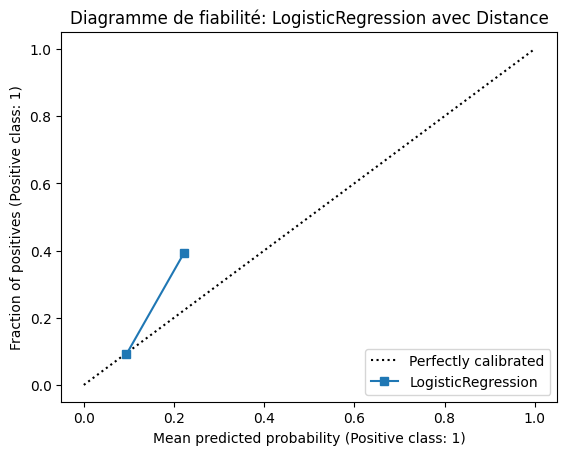

In [26]:
CalibrationDisplay.from_estimator(clf, X_val, y_val)
#CalibrationDisplay.from_predictions(y_val, goal_probabilities)
plt.title('Diagramme de fiabilité: LogisticRegression avec Distance')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect3_fiabilite_distance_LR.png', dpi=150)
plt.show()

**3.Avec deux classifieurs**
   
*1- uniquement les angles*

In [25]:
df_q2 = df_q1.dropna(subset=['ANGLE','IS_GOAL'])
X = df_q2[['ANGLE']]
y = df_q2['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )
clf = LogisticRegression()
clf.fit( X_train, y_train)
y_pred = clf.predict(X_val)
y_score = clf.predict_proba(X_val)
goal_probabilities = y_score[:, 1]

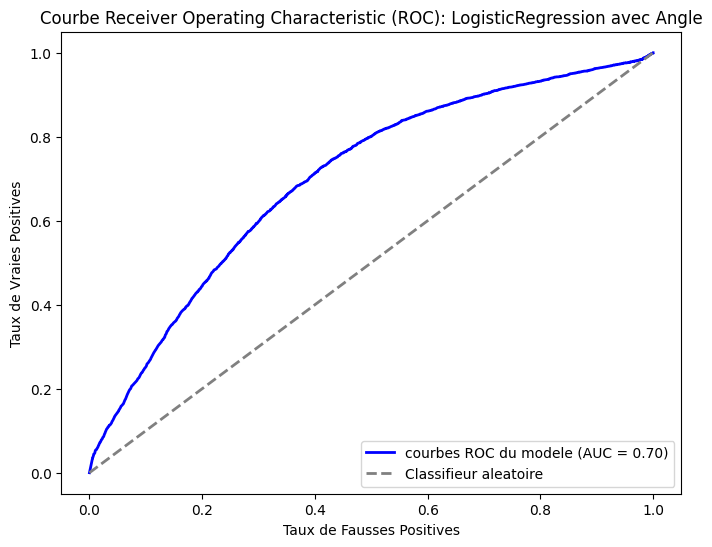

In [40]:
tracer_courbe_roc(y_val, goal_probabilities, 'LogisticRegression avec Angle','/milestone2/image/sect3_roc_angle_LR.png')

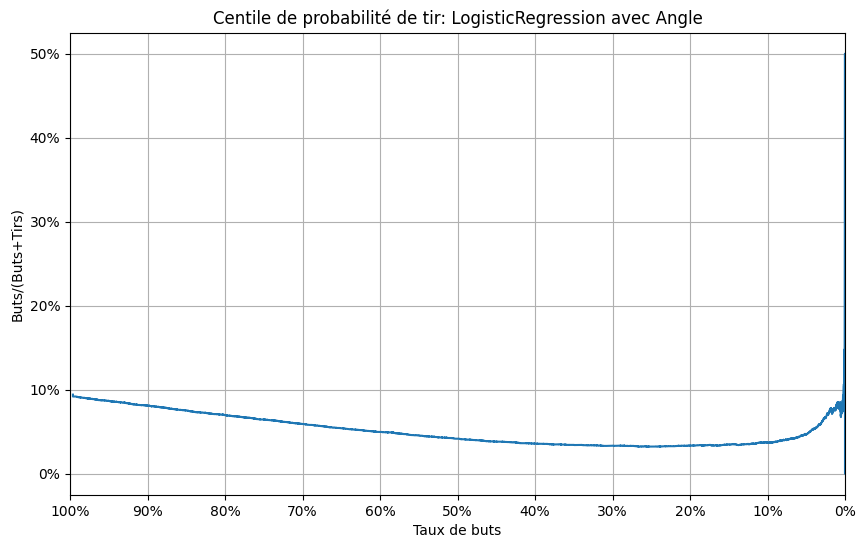

In [39]:
trace_courbe_taux_buts(y_val, goal_probabilities,'LogisticRegression avec Angle','/milestone2/image/sect3_taux_angle_LR.png' )

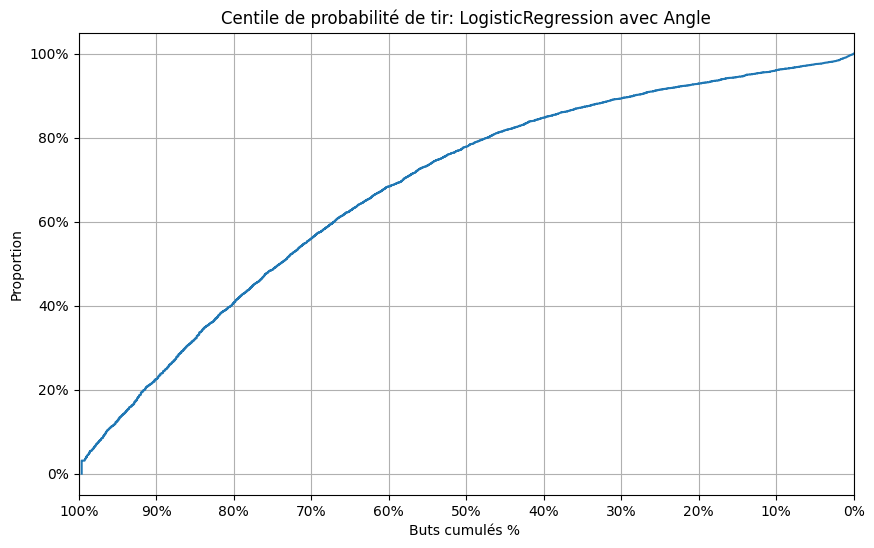

In [38]:
tracer_courbe_proportion(y_val, goal_probabilities, 'LogisticRegression avec Angle','/milestone2/image/sect3_proportion_angle_LR.png')

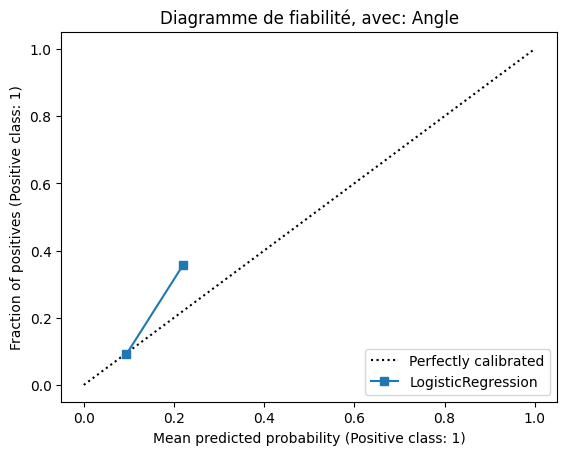

In [37]:
CalibrationDisplay.from_estimator(clf, X_val, y_val)
#CalibrationDisplay.from_predictions(y_val, goal_probabilities)
plt.title('Diagramme de fiabilité, avec: Angle')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect3_fiabilite_angle_LR.png', dpi=150)
plt.show()

*2- les angles et distances*

In [30]:
df_q2 = df_q1.dropna(subset=['ANGLE','DISTANCE','IS_GOAL'])
X = df_q2[['ANGLE','DISTANCE']]
y = df_q2['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )
clf = LogisticRegression()
clf.fit( X_train, y_train) 
y_pred = clf.predict(X_val)
y_score = clf.predict_proba(X_val)
goal_probabilities = y_score[:, 1]

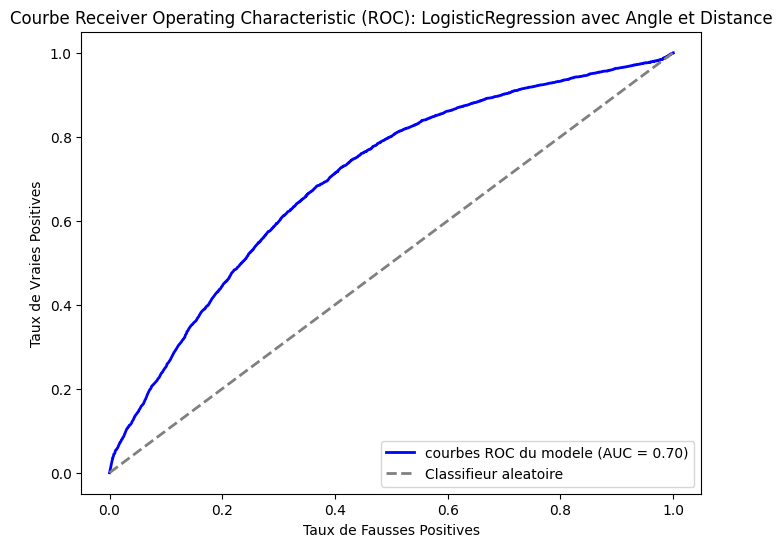

In [31]:
tracer_courbe_roc(y_val, goal_probabilities, 'LogisticRegression avec Angle et Distance', '/milestone2/image/sect3_roc_angle_distance_LR.png')

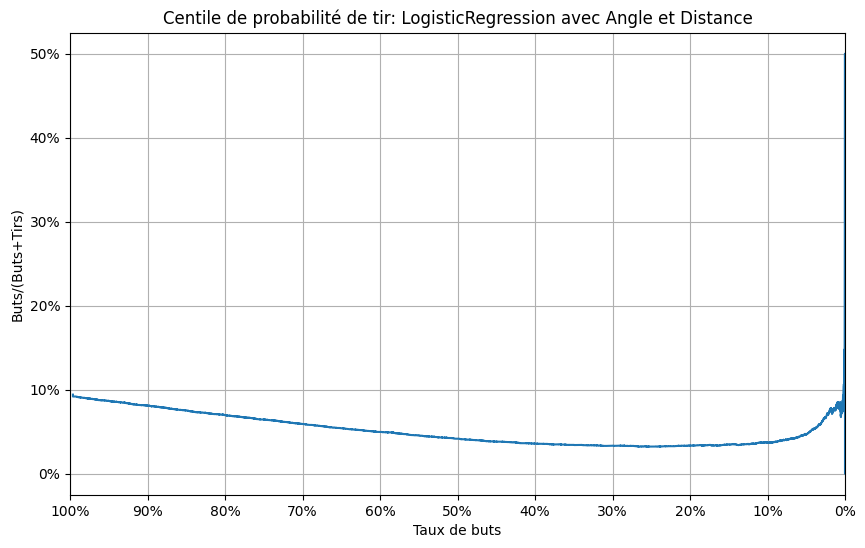

In [34]:
trace_courbe_taux_buts(y_val, goal_probabilities,'LogisticRegression avec Angle et Distance','/milestone2/image/sect3_taux_angle_distance_LR.png' )

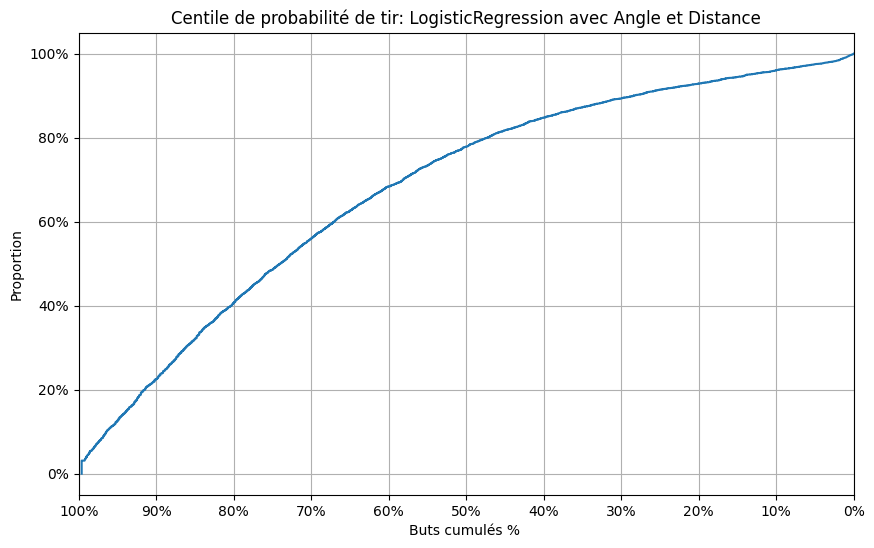

In [35]:
tracer_courbe_proportion(y_val, goal_probabilities, 'LogisticRegression avec Angle et Distance','/milestone2/image/sect3_prop_angle_distance_LR.png')

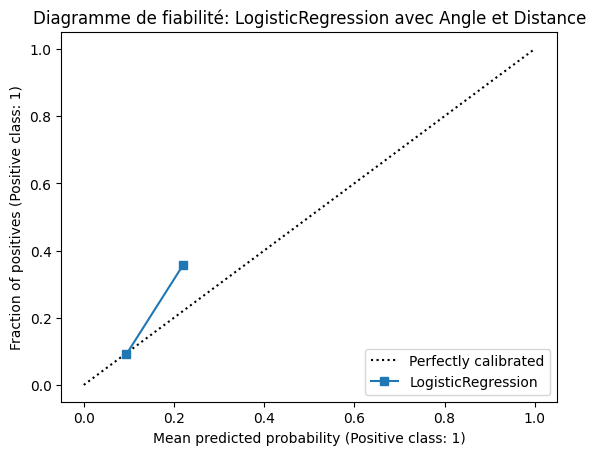

In [36]:
CalibrationDisplay.from_estimator(clf, X_val, y_val)
#CalibrationDisplay.from_predictions(y_val, goal_probabilities)
plt.title('Diagramme de fiabilité: LogisticRegression avec Angle et Distance')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect3_fiabilite_angle_distance_LR.png', dpi=150)
plt.show()

**Section 4**

In [42]:
df_s4 = partie4('/home/mchelfi/Desktop/PROJET_NHL/2017021065.json')
df_s4.head()

,PERIOD_TIME,LAST_ELAPSED_TIME,PERIOD,COORD_X,COORD_Y,LAST_COORD_X,LAST_COORD_Y,DISTANCE,LAST_DISTANCE,ANGLE,SHOT_TYPE,LAST_EVENT_ID,IS_EMPTY_NET,IS_GOAL,REBOND,CHANGE_ANGLE,SPEED,SPEED_ANGLE
0,111,11,1,-50,36,72,37,143.586211,122.004098,14.520149,snap,503,0,0,False,0.000000,11.091282,0.000000
1,115,4,1,-85,-25,-50,36,175.786803,70.327804,-8.176197,wrist,506,0,0,True,-22.696346,17.581951,-5.674087
2,124,1,1,73,-16,-39,-28,22.627417,112.641023,-45.000000,backhand,525,0,0,False,0.000000,112.641023,0.000000
3,151,5,1,-29,-6,10,38,118.152444,58.796258,-2.910838,slap,503,0,0,False,0.000000,11.759252,0.000000
4,159,8,1,23,-34,-29,-6,74.242845,59.059292,-27.255328,wrist,506,0,0,True,-24.344491,7.382412,-3.043061


In [44]:
df_s4.columns.to_list()

['PERIOD_TIME',
 'LAST_ELAPSED_TIME',
 'PERIOD',
 'COORD_X',
 'COORD_Y',
 'LAST_COORD_X',
 'LAST_COORD_Y',
 'DISTANCE',
 'LAST_DISTANCE',
 'ANGLE',
 'SHOT_TYPE',
 'LAST_EVENT_ID',
 'IS_EMPTY_NET',
 'IS_GOAL',
 'REBOND',
 'CHANGE_ANGLE',
 'SPEED',
 'SPEED_ANGLE']

**Section 5**\
*Section 5.1*

In [47]:
df_s5 = df_q1.dropna(subset=['DISTANCE','IS_GOAL'])
X = df_s5[['DISTANCE']]
y = df_s5['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_val = xgb.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 3,  
    'eta': 0.3,      
    'objective': 'binary:logistic',
    #'num_class': 2,
    'eval_metric': 'auc'
}
num_round = 20

bst = xgb.train(params, xg_train, num_round)

goal_probabilities = bst.predict(xg_val)


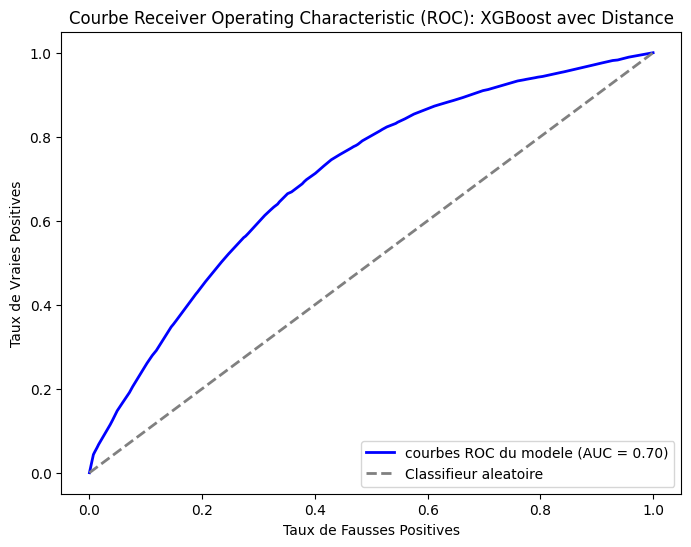

In [48]:
tracer_courbe_roc(y_val, goal_probabilities, 'XGBoost avec Distance', '/milestone2/image/sect5_roc_distance_XGB.png')

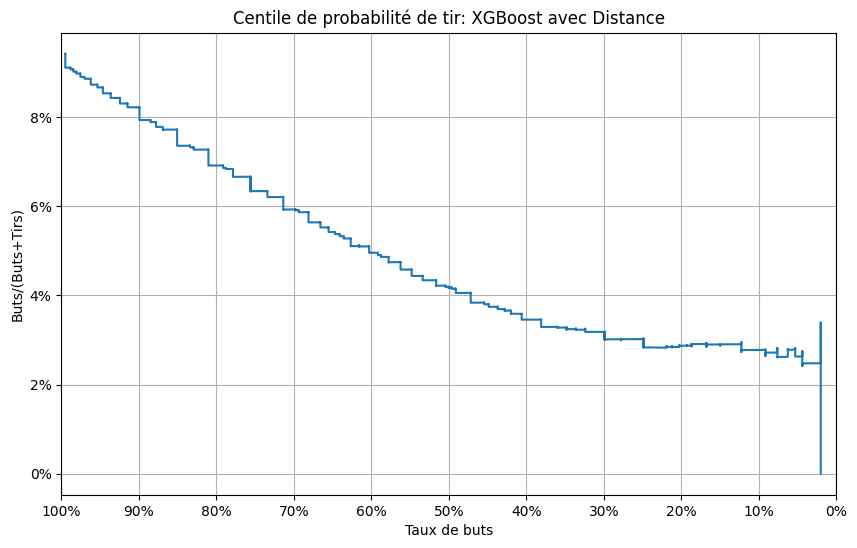

In [50]:
trace_courbe_taux_buts(y_val, goal_probabilities,'XGBoost avec Distance','/milestone2/image/sect5_taux_distance_XGB.png')

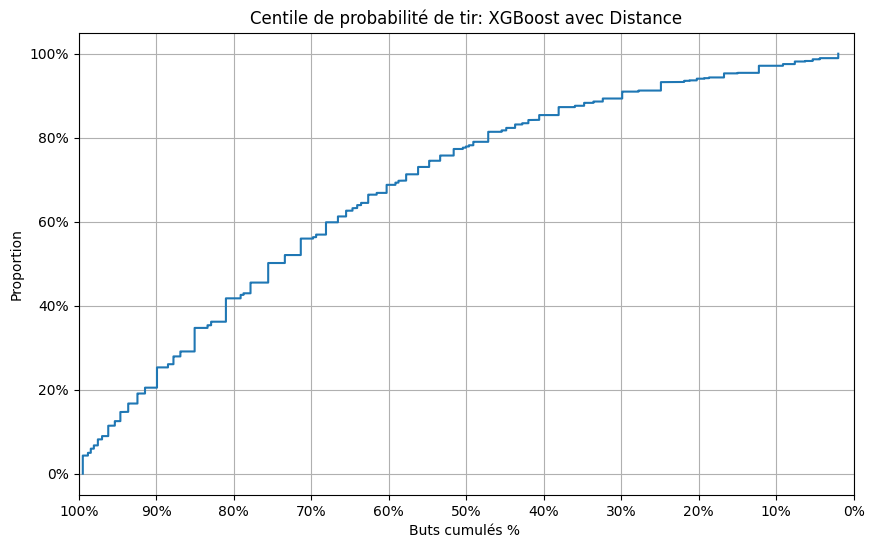

In [51]:
tracer_courbe_proportion(y_val, goal_probabilities, 'XGBoost avec Distance','/milestone2/image/sect5_prop_distance_XGB.png')

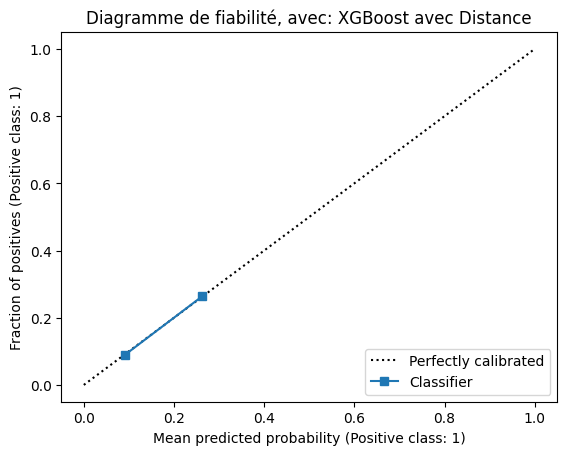

In [52]:
CalibrationDisplay.from_predictions(y_val, goal_probabilities)
plt.title('Diagramme de fiabilité, avec: XGBoost avec Distance')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect5_fiabilite_distance_XGB.png', dpi=150)
plt.show()

In [61]:
df_s5 = df_q1.dropna(subset=['ANGLE','IS_GOAL'])
X = df_s5[['ANGLE']]
y = df_s5['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_val = xgb.DMatrix(X_val, label=y_val)

param = {
    'max_depth': 3,  
    'eta': 0.3,      
    'objective': 'binary:logistic',
    #'num_class': 2,
    'eval_metric': 'auc'
}
num_round = 20

bst = xgb.train(param, xg_train, num_round)
goal_probabilities = bst.predict(xg_val)


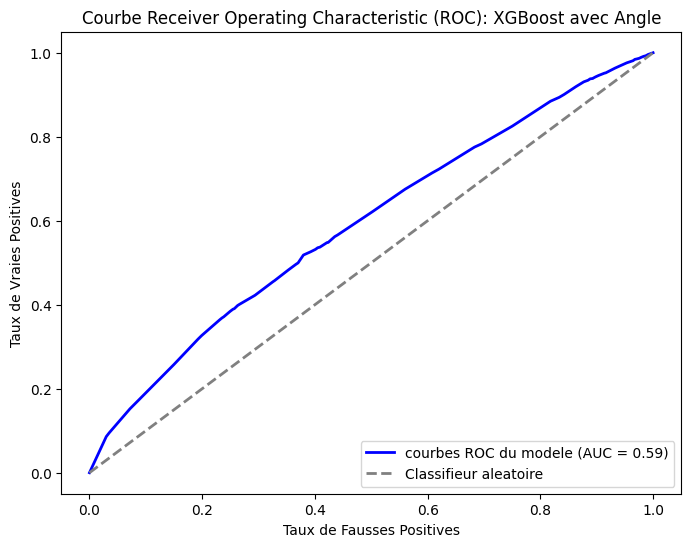

In [62]:
tracer_courbe_roc(y_val, goal_probabilities, 'XGBoost avec Angle','/milestone2/image/sect5_ron_distance_XGB.png')

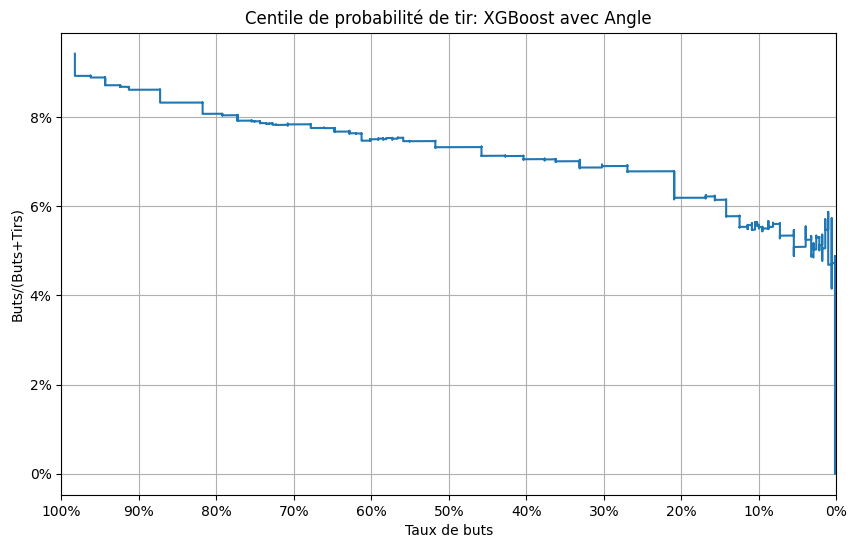

In [55]:
trace_courbe_taux_buts(y_val, goal_probabilities,'XGBoost avec Angle','/milestone2/image/sect5_taux_angle_XGB.png' )

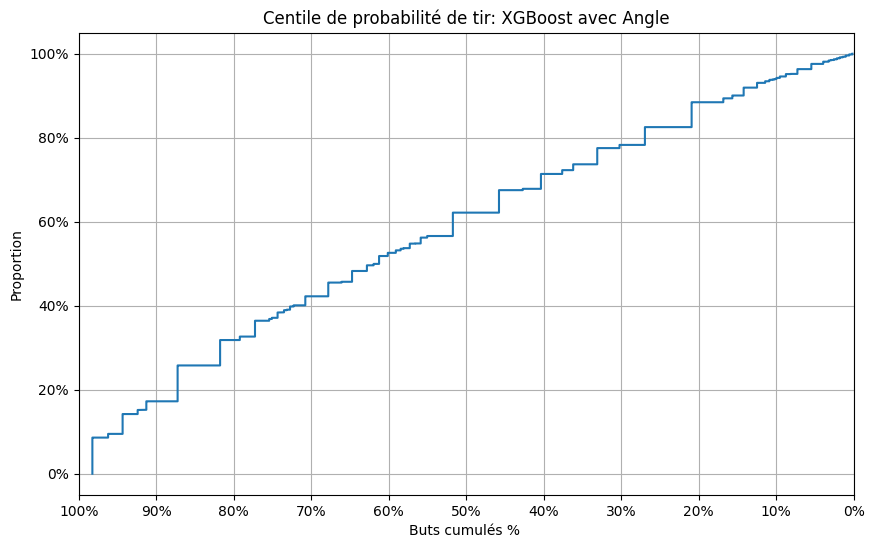

In [56]:
tracer_courbe_proportion(y_val, goal_probabilities, 'XGBoost avec Angle','/milestone2/image/sect5_prop_angle_XGB.png')

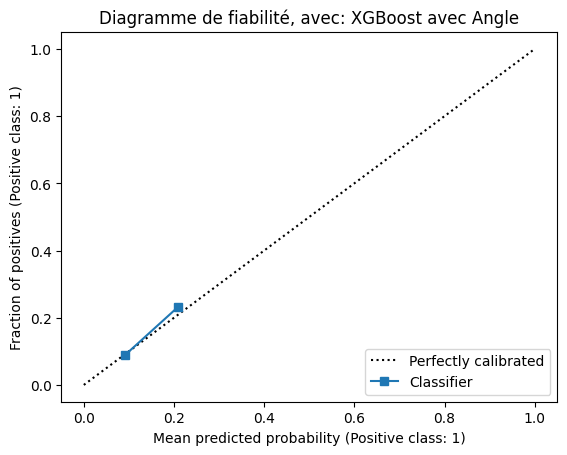

In [57]:
CalibrationDisplay.from_predictions(y_val, goal_probabilities)
plt.title('Diagramme de fiabilité, avec: XGBoost avec Angle')
#plt.savefig('/home/mchelfi/Desktop/PROJET_NHL/blog_website/milestone2/image/sect5_fiabilite_angle_XGB.png', dpi=150)
plt.show()

*Section 5.2*

In [3]:
df_s5 = partie4(data_path)

In [26]:
X = df_s5.drop('IS_GOAL',axis=1)
y =  df_s5['IS_GOAL']

le = LabelEncoder()
X['LAST_EVENT_ID'] = le.fit_transform(X['LAST_EVENT_ID'])
X['SHOT_TYPE'] = le.fit_transform(X['SHOT_TYPE'])

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.4],
    'n_estimators': [100, 200, 500],
    'subsample': [0.7, 0.8, 1]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy')


grid_search.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.4],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.7, 0.8, 1]},
             scoring='accuracy', verbose=1)

In [27]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_score,best_params)

0.9095359275025998 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


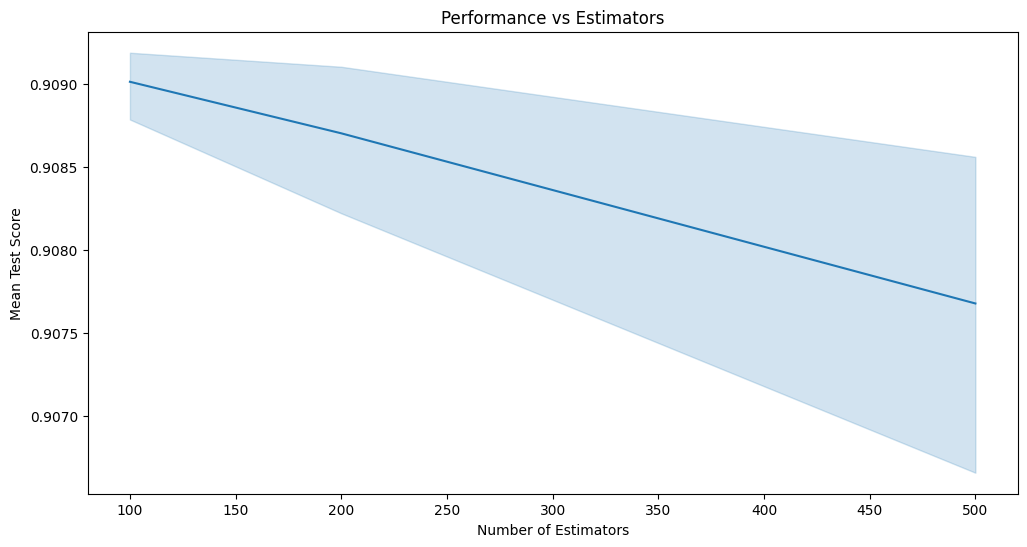

In [29]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))
sb.lineplot(x="param_n_estimators", y="mean_test_score", data=results)
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Performance vs Estimators')
plt.show()

**Section 6**

In [ ]:
df_s5 = partie4(data_path)
df = df_s5.dropna(subset=['DISTANCE','IS_GOAL'])

In [88]:
le = LabelEncoder()
df['LAST_EVENT_ID'] = le.fit_transform(df['LAST_EVENT_ID'])
df['SHOT_TYPE'] = le.fit_transform(df['SHOT_TYPE'])
X = df.drop(['IS_GOAL'],axis=1)
y = df[['IS_GOAL']]
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )
rfModel = RandomForestClassifier(n_estimators=100, random_state=42)
rfModel.fit(X_train, y_train)
y_pred = rfModel.predict(X_val)
report = classification_report(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f"The accuracy of our model is: {accuracy}")
print(report)

The accuracy of our model is: 0.906983400114482
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9464
           1       0.73      0.07      0.12      1018

    accuracy                           0.91     10482
   macro avg       0.82      0.53      0.54     10482
weighted avg       0.89      0.91      0.87     10482



In [103]:
goal_probabilities = rfModel.predict_proba(X_val)




**Section 7**

In [71]:
df_train = organiser(data_path,2020,2020)
df_train = encode_column(df_train, 'IS_EMPTY_NET')
df_train = encode_column(df_train, 'IS_GOAL')

df_train['DISTANCE'] = df_train.apply(lambda row: distance(row), axis=1)
df_train['ANGLE'] = df_train.apply(lambda row: angle(row), axis=1)

df_s4 = df_train[
        ['PERIOD_TIME', 'LAST_ELAPSED_TIME', 'PERIOD', 'COORD_X', 'COORD_Y', 'LAST_COORD_X', 'LAST_COORD_Y', 'DISTANCE',
         'LAST_DISTANCE', 'ANGLE', 'SHOT_TYPE', 'LAST_EVENT_ID', 'RINK_SIDE','IS_EMPTY_NET', 'IS_GOAL']].copy()

df_s4['PERIOD_TIME'] = df_s4['PERIOD_TIME'].apply(toseconds)
df_s4['REBOND'] = df_s4.apply(lambda row: True if row['LAST_EVENT_ID'] == 506 else False, axis=1)
df_s4['CHANGE_ANGLE'] = df_s4.apply(lambda row: row['ANGLE'] - angle(row, True) if row['REBOND'] else 0,axis=1)

df_s4['SPEED'] = df_s4.apply(
        lambda row: row['LAST_DISTANCE'] / row['LAST_ELAPSED_TIME'] if row['LAST_ELAPSED_TIME'] != 0 else 0, axis=1)

df_s4['SPEED_ANGLE'] = df_s4.apply(
       lambda row: row['CHANGE_ANGLE'] / row['LAST_ELAPSED_TIME'] if row['LAST_ELAPSED_TIME'] != 0 else 0, axis=1)

df_s4 = df_s4.drop('RINK_SIDE', axis=1)

df_test = df_s4

df = df_test.dropna(subset=['DISTANCE','IS_GOAL'])
le = LabelEncoder()
df['LAST_EVENT_ID'] = le.fit_transform(df['LAST_EVENT_ID'])
df['SHOT_TYPE'] = le.fit_transform(df['SHOT_TYPE'])

X = df.drop(['IS_GOAL'],axis=1)
y = df['IS_GOAL']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42 )
rfModel = RandomForestClassifier(n_estimators=100, random_state=42)
rfModel.fit(X_train, y_train)
y_pred = rfModel.predict(X_val)
report = classification_report(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
print(f"The accuracy of our model is: {accuracy}")
print(report)

The accuracy of our model is: 0.906983400114482
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9464
           1       0.73      0.07      0.12      1018

    accuracy                           0.91     10482
   macro avg       0.82      0.53      0.54     10482
weighted avg       0.89      0.91      0.87     10482

